<a href="https://colab.research.google.com/github/sorochinsky/bigdataschool/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Hillel_Final_Progect_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом проекте я хотел бы построить нейронную сеть, которая будет классифыцировать геометрические объекты. Второй частью хотелось бы определять их место положение на изображении и отрисовывать границы.

In [ ]:
import numpy as np
#import cv2
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot

import random
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator, load_img
import os, shutil
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
dir = '/gdrive/My Drive/figures/train/'
if not os.path.exists(dir):
    os.mkdir(dir)

Создадим два типа объектов - круг и триугольник.

In [ ]:
def make_circle(n=1000, dirc = '/gdrive/My Drive/figures/train/'):
    i_list = []
    c1_list = []
    c2_list = []
    r_list = []

    for i in range(n):
        fig = pyplot.figure(figsize=[1, 1])
        r = random.random()
        c1 = random.random()
        c2 = random.random()

        circle = pyplot.Circle((c1, c2), radius=r, color='gray', fill=True)
        pyplot.gca().add_patch(circle)
        pyplot.axis('off')
        pyplot.ylim(top=1.5, bottom=-1.5)
        pyplot.xlim(right=-1.5, left=1.5)
        #pyplot.show()
        fig.savefig('{}circle_{}.png'.format(dirc, i))


        i_list.append(i)
        c1_list.append(c1)
        c2_list.append(c2)
        r_list.append(r)

    circle_table = pd.DataFrame({'id': i_list, 'c1': c1_list, 'c2': c2_list, 'r': r_list})
    circle_table.to_csv('/gdrive/My Drive/figures/circle_table.csv',index=False)
    pyplot.close('all')


In [ ]:
def make_triangle(n=1000, dirc = '/gdrive/My Drive/figures/train/'):
    i_list = []
    a_list = []
    b_list = []
    c_list = []
    for i in range(n):
        a = random.random()
        b = random.random()
        c = random.random()

        fig = pyplot.figure(figsize=[1, 1])
        points = [[a, b], [b, c],[c, a]]
        polygon = pyplot.Polygon(points, color='gray')
        pyplot.gca().add_patch(polygon)
        pyplot.axis('off')
        fig.savefig('{}triangle_{}.png'.format(dirc, i))

        i_list.append(i)
        a_list.append(a)
        b_list.append(b)
        c_list.append(c)

    triangle_table = pd.DataFrame({'id': i_list, 'a': a_list, 'b': b_list, 'c': c_list})
    triangle_table.to_csv('/gdrive/My Drive/figures/triangle_table.csv',index=False)
    pyplot.close('all')

In [ ]:
make_circle(n=1000)
make_triangle(n=1000)

In [ ]:
#создадим таблицу с названиями файлов, что у нас есть
filenames = os.listdir('/gdrive/My Drive/figures/train/')
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'triangle':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.shape

(2000, 2)

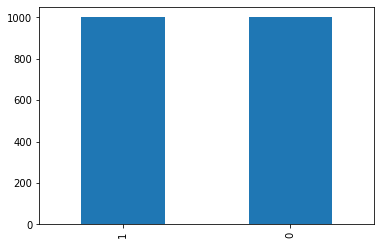

In [ ]:
import matplotlib
df['category'].value_counts().plot.bar()

Архитектуру сети я взял из примера с котами и собаками

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(72, 72, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

#reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


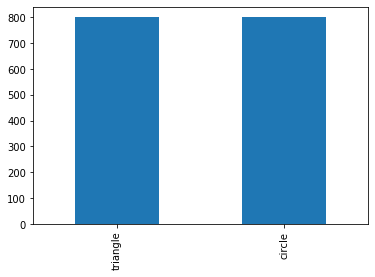

In [ ]:
#разделяем на тренировочную и валидационную выборки
df["category"] = df["category"].replace({0: 'circle', 1: 'triangle'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    '/gdrive/My Drive/figures/train/',
    x_col='filename',
    y_col='category',
    target_size=(72, 72),
    class_mode='categorical',
    batch_size=20
)

Found 1600 validated image filenames belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    '/gdrive/My Drive/figures/train/',
    x_col='filename',
    y_col='category',
    target_size=(72, 72),
    class_mode='categorical',
    batch_size=20
)

Found 400 validated image filenames belonging to 2 classes.


In [ ]:
#тренируем сеть
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 20

history = model.fit_generator(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)




Epoch 1/10





80/80 [==============================] - 19s 233ms/step - loss: 0.6297 - acc: 0.7241 - val_loss: 0.4964 - val_acc: 0.8712
Epoch 2/10
80/80 [==============================] - 17s 216ms/step - loss: 0.3487 - acc: 0.8922 - val_loss: 0.2541 - val_acc: 0.9587
Epoch 3/10
80/80 [==============================] - 18s 222ms/step - loss: 0.1857 - acc: 0.9378 - val_loss: 0.2141 - val_acc: 0.9075
Epoch 4/10
80/80 [==============================] - 17s 215ms/step - loss: 0.1256 - acc: 0.9556 - val_loss: 0.1194 - val_acc: 0.9437

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/10
80/80 [==============================] - 18s 224ms/step - loss: 0.0768 - acc: 0.9806 - val_loss: 0.1112 - val_acc: 0.9600
Epoch 6/10
80/80 [==============================] - 17s 217ms/step - loss: 0.0598 - acc: 0.9837 - val_loss: 0.0742 - val_acc: 0.9712
Epoch 7/10
80/80 [==============================] - 17s 216ms/step - loss: 0.0486 - acc: 0.9847 - val_loss: 0.064

In [ ]:
model.save_weights("model.h5")

In [ ]:
#для теста создадим несколько новых фигур
dir = '/gdrive/My Drive/figures/test/'
if not os.path.exists(dir):
    os.mkdir(dir)

make_circle(n=100, dirc = dir)
make_triangle(n=100, dirc = dir)

In [ ]:
#создадим таблицу с названиями файлов, что у нас есть
filenames = os.listdir(dir)
categories = []
for filename in filenames:
    category = filename.split('_')[0]
    if category == 'triangle':
        categories.append(1)
    else:
        categories.append(0)

test_df = pd.DataFrame({
    'filename': filenames,
    'category_fact': categories
})

In [ ]:
test_df.shape

(200, 2)

In [ ]:
#аналогичное преобразование файлов
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    dir,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(72, 72),
    batch_size=batch_size,
    shuffle=False
)

Found 200 validated image filenames.


In [ ]:
#прогнозируем категорию
predict = model.predict_generator(test_generator)

In [ ]:
test_df['category_predict'] = np.argmax(predict, axis=-1)

In [ ]:
test_df.head()

,filename,category_fact,category_predict
0,circle_0.png,0,0
1,circle_1.png,0,0
2,circle_2.png,0,0
3,circle_3.png,0,0
4,circle_4.png,0,0


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_df.category_fact, test_df.category_predict)

0.995

In [ ]:
test_df[test_df.category_fact != test_df.category_predict]

,filename,category_fact,category_predict
19,circle_19.png,0,1


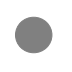

In [ ]:
image = load_img('/gdrive/My Drive/figures/test/circle_19.png')
image

Всего одну фигуру распознало неправильно, хотя на вид это четкий круг. В любом случаи сеть с легкостью дала результат 99,5% точности на таких простых фигурах. Не удивительно, ведь, она хорошо распознает даже собак и котов.

Поиск координат:

In [ ]:
input_dim = 72

from PIL import Image , ImageDraw
import os
import glob

images = []
image_paths = glob.glob( '/gdrive/My Drive/figures/train/*.png' )
for imagefile in image_paths[-1000:]:
    image = Image.open(imagefile).resize((input_dim, input_dim))
    image = np.asarray(image) / 255.0
    images.append(image)

In [ ]:
len(images)

1000

In [ ]:
circle_table = pd.read_csv('/gdrive/My Drive/figures/circle_table.csv')

In [ ]:
circle_table[circle_table.id == 19]

,id,c1,c2,r
19,19,0.731726,0.529695,0.276899


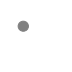

In [ ]:
image = load_img('/gdrive/My Drive/figures/train/circle_19.png')
image

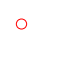

In [ ]:
fig = pyplot.figure(figsize=[1, 1])
r = circle_table[circle_table.id == 19].r
c1 = circle_table[circle_table.id == 19].c1
c2 = circle_table[circle_table.id == 19].c2

circle = pyplot.Circle((c1, c2), radius=r, color='red', fill=False)
pyplot.gca().add_patch(circle)
pyplot.axis('off')
pyplot.ylim(top=1.5, bottom=-1.5)
pyplot.xlim(right=-1.5, left=1.5)
pyplot.show()

In [ ]:
circles = np.array(circle_table[['c1', 'c2', 'r']])

In [ ]:
circles[19]

array([0.73172638, 0.52969452, 0.27689949])

In [ ]:
Y = circles
X = np.array(images)

x_train, x_test, y_train, y_test = train_test_split( X, Y, test_size=0.2 )

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(72, 72, 4)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(3, activation='relu'))


from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['mse'])

#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

#reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [ ]:
model.fit(
    x_train ,
    y_train ,
    validation_data=( x_test , y_test ),
    epochs=100,
    batch_size=20
)


Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 7s 9ms/step - loss: 0.5646 - mean_squared_error: 0.0161 - val_loss: 0.5426 - val_mean_squared_error: 0.0088
Epoch 2/100
800/800 [==============================] - 7s 9ms/step - loss: 0.5476 - mean_squared_error: 0.0135 - val_loss: 0.5465 - val_mean_squared_error: 0.0087
Epoch 3/100
800/800 [==============================] - 7s 9ms/step - loss: 0.5462 - mean_squared_error: 0.0121 - val_loss: 0.6043 - val_mean_squared_error: 0.0235
Epoch 4/100
800/800 [==============================] - 7s 9ms/step - loss: 0.5502 - mean_squared_error: 0.0122 - val_loss: 0.5353 - val_mean_squared_error: 0.0061
Epoch 5/100
800/800 [==============================] - 8s 9ms/step - loss: 0.5406 - mean_squared_error: 0.0105 - val_loss: 0.5326 - val_mean_squared_error: 0.0051
Epoch 6/100
800/800 [==============================] - 7s 9ms/step - loss: 0.5421 - mean_squared_error: 0.0095 - val_loss: 0.5290 - val_mea

In [ ]:
dir = '/gdrive/My Drive/figures/test/'
if not os.path.exists(dir):
    os.mkdir(dir)

make_circle(n=100, dirc = dir)

In [ ]:
images_test = []
image_paths = glob.glob( '/gdrive/My Drive/figures/test/*.png' )
for imagefile in image_paths:
    image = Image.open(imagefile).resize((input_dim, input_dim))
    image = np.asarray(image) / 255.0
    images_test.append(image)

In [ ]:
circle_table_test = pd.read_csv('/gdrive/My Drive/figures/circle_table.csv')

In [ ]:
predict = model.predict(np.array(images_test))

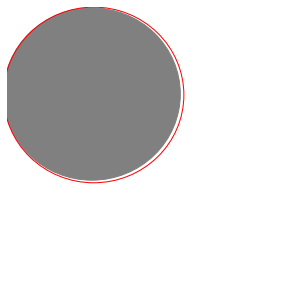

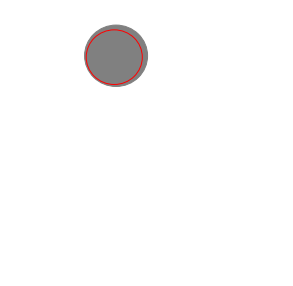

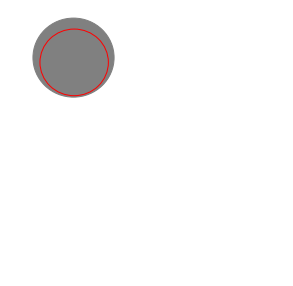

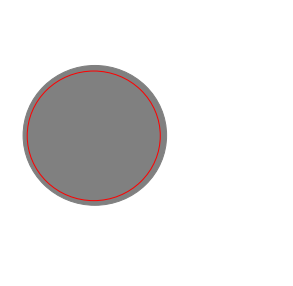

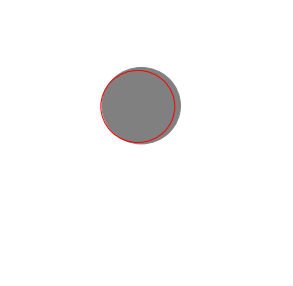

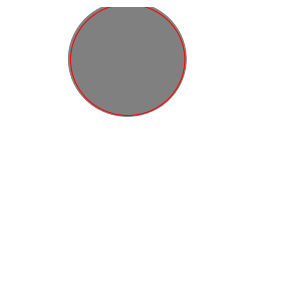

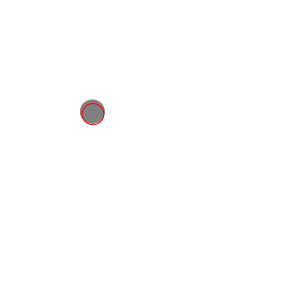

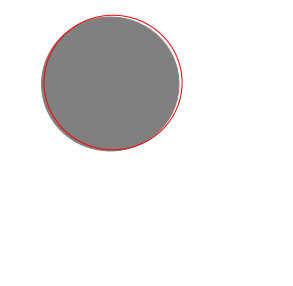

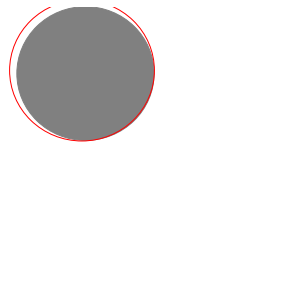

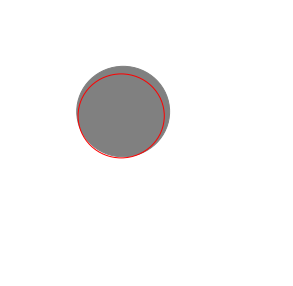

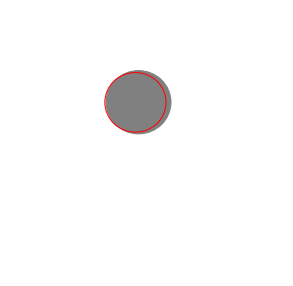

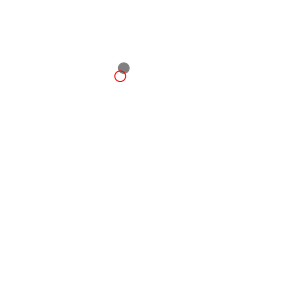

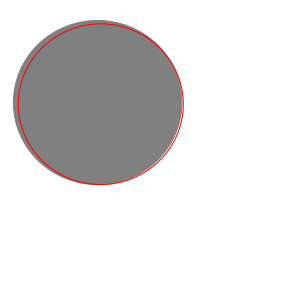

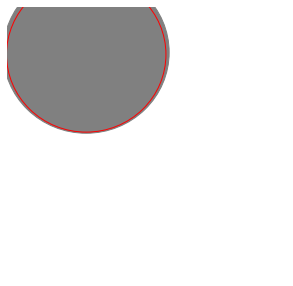

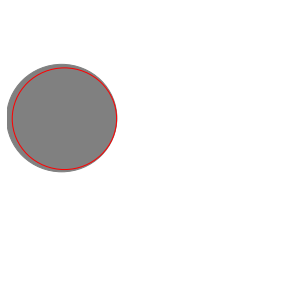

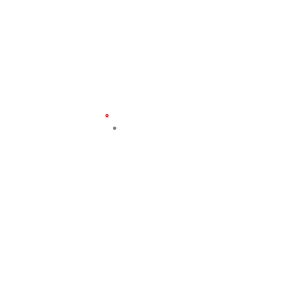

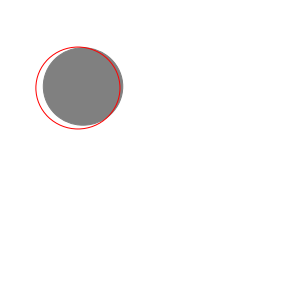

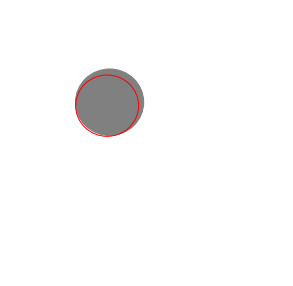

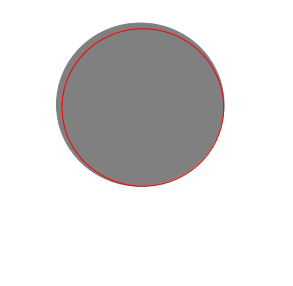

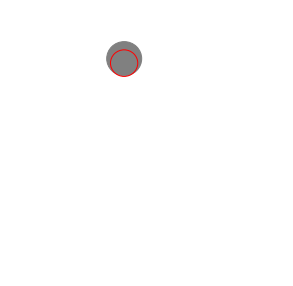

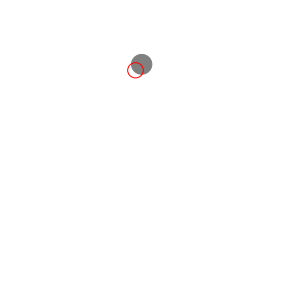

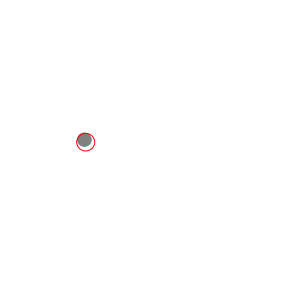

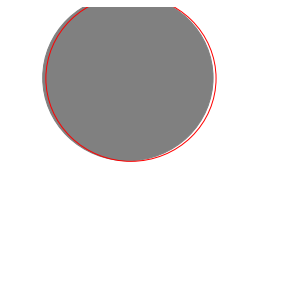

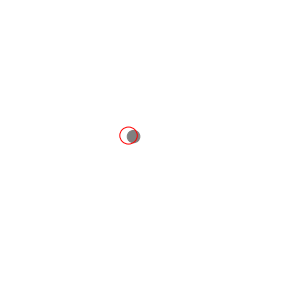

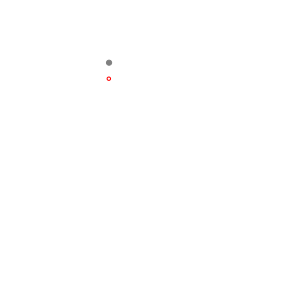

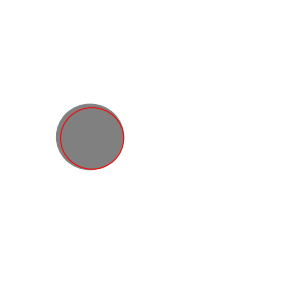

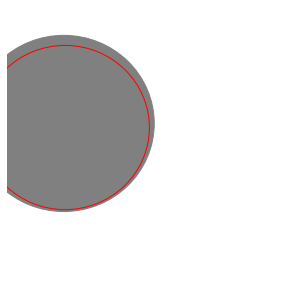

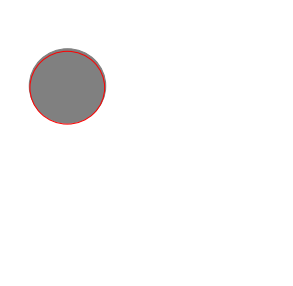

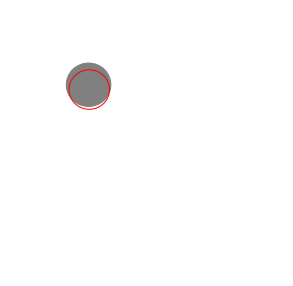

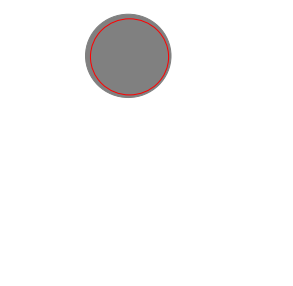

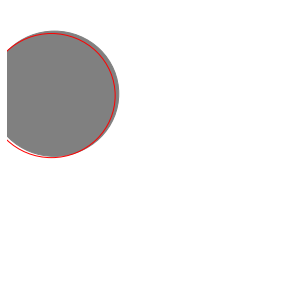

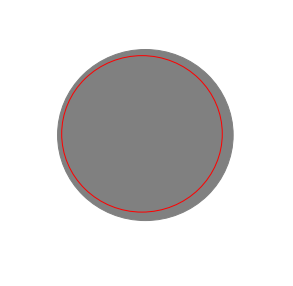

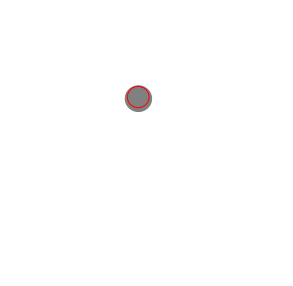

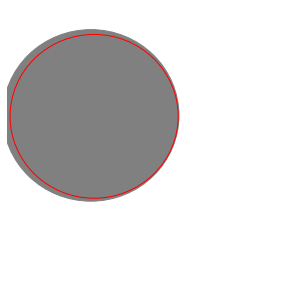

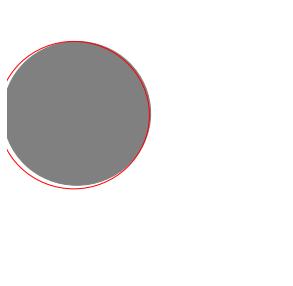

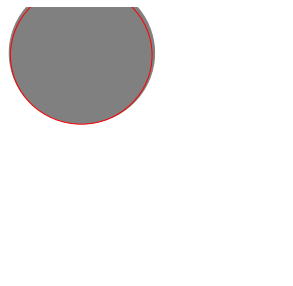

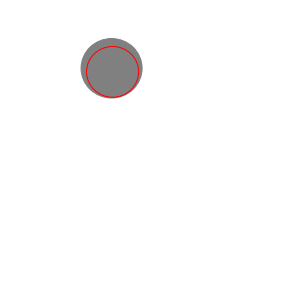

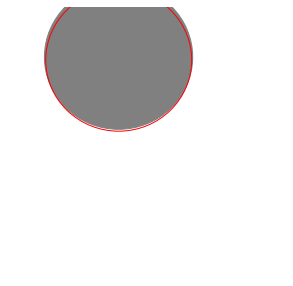

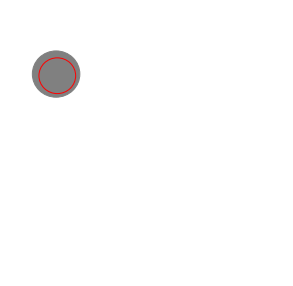

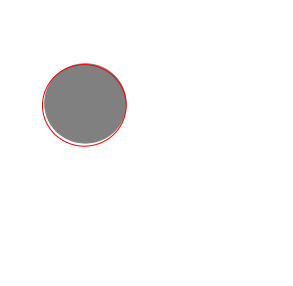

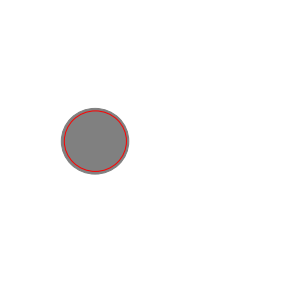

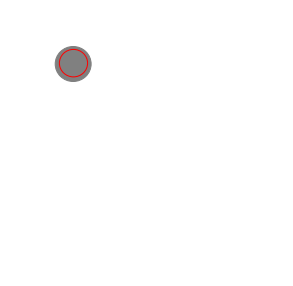

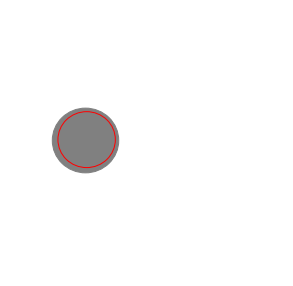

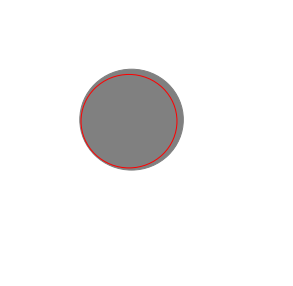

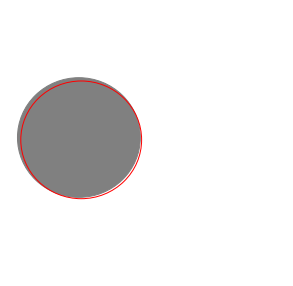

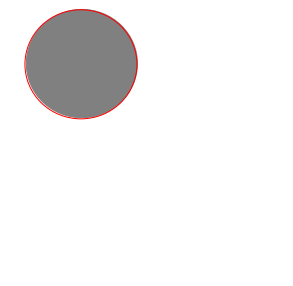

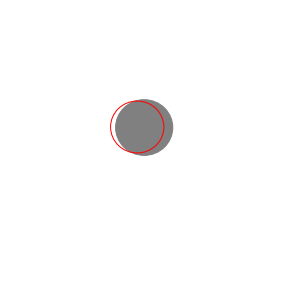

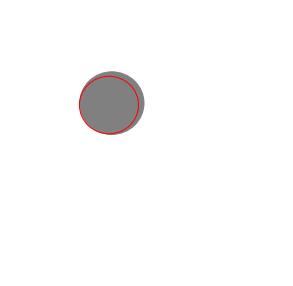

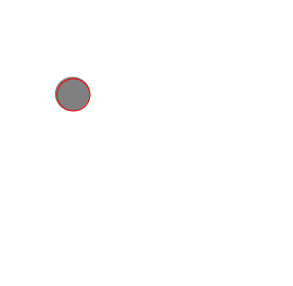

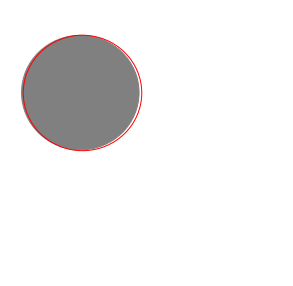

In [ ]:
for i in range(50):
  fig = pyplot.figure(figsize=[5, 5])
  r = circle_table_test[circle_table_test.id == i].r
  c1 = circle_table_test[circle_table_test.id == i].c1
  c2 = circle_table_test[circle_table_test.id == i].c2

  circle = pyplot.Circle((c1, c2), radius=r, color='gray', fill=True)

  prdct =  pyplot.Circle((predict[i][0], predict[i][1]), radius=predict[i][2], color='red', fill=False)

  pyplot.gca().add_patch(circle)
  pyplot.gca().add_patch(prdct)
  pyplot.axis('off')
  pyplot.ylim(top=1.5, bottom=-1.5)
  pyplot.xlim(right=-1.5, left=1.5)
  pyplot.show()

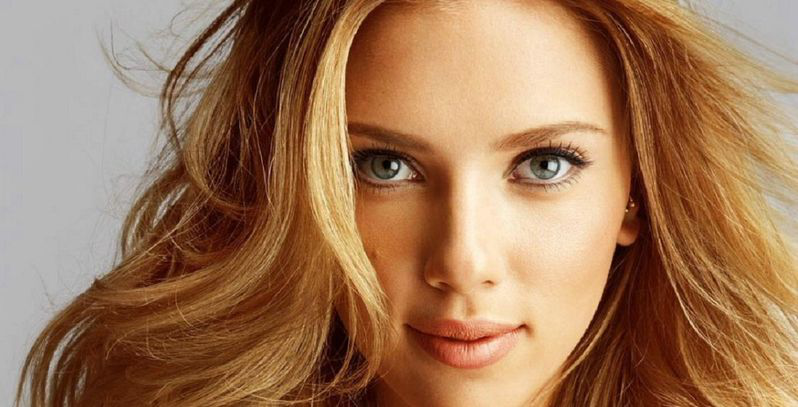

In [ ]:
url = 'https://wuzzup.ru/wp-content/uploads/2016/03/Scarlett-Johansson-17.jpg'

from PIL import Image
import requests
from io import BytesIO
url = 'https://static1.therichestimages.com/wordpress/wp-content/uploads/2016/06/Scarlett-Johansson-1.jpg?q=50&fit=crop&w=798&h=407'
response = requests.get(url)
img_pil = Image.open(BytesIO(response.content))

img_pil

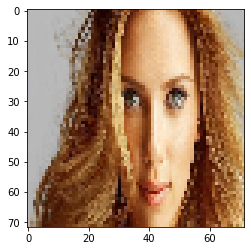

In [ ]:
image = img_pil.resize((input_dim, input_dim))
image = np.asarray(image) / 255.0
image
imgplot = plt.imshow(image)

In [ ]:
predict = model.predict(np.array(image))

ValueError: ignored